# AGIPD Offline Correction #

Author: European XFEL Detector Group, Version: 2.0

Offline Calibration for the AGIPD Detector

In [1]:
in_folder = "/gpfs/exfel/exp/SPB/201931/p900086/raw" # the folder to read data from, required
out_folder = "/gpfs/exfel/data/scratch/kluyvert/agipd-calib-xmpl"  # the folder to output to, required
sequences = [0] # sequences to correct, set to -1 for all, range allowed
modules = [-1] # modules to correct, set to -1 for all, range allowed
run = 14 # runs to process, required

karabo_id = "SPB_DET_AGIPD1M-1" # karabo karabo_id
karabo_da = ['-1']  # a list of data aggregators names, Default [-1] for selecting all data aggregators
receiver_id = "{}CH0" # inset for receiver devices
path_template = 'RAW-R{:04d}-{}-S{:05d}.h5' # the template to use to access data
h5path = 'INSTRUMENT/{}/DET/{}:xtdf/' # path in the HDF5 file to images
h5path_idx = 'INDEX/{}/DET/{}:xtdf/' # path in the HDF5 file to images
h5path_ctrl = '/CONTROL/{}/MDL/FPGA_COMP' # path to control information
karabo_id_control = "SPB_IRU_AGIPD1M1" # karabo-id for control device
karabo_da_control = '' # karabo DA for control infromation

slopes_ff_from_files = "" # Path to locally stored SlopesFF and BadPixelsFF constants

use_dir_creation_date = True # use the creation data of the input dir for database queries
cal_db_interface = "tcp://max-exfl016:8015#8045" # the database interface to use
cal_db_timeout = 30000 # in milli seconds
creation_date_offset = "00:00:00" # add an offset to creation date, e.g. to get different constants

max_cells = 0 # number of memory cells used, set to 0 to automatically infer
bias_voltage = 300 # Bias voltage
acq_rate = 0. # the detector acquisition rate, use 0 to try to auto-determine
gain_setting = 0.1 # the gain setting, use 0.1 to try to auto-determine
photon_energy = 9.2 # photon energy in keV
overwrite = True # set to True if existing data should be overwritten
max_pulses = [0, 500, 1] # range list [st, end, step] of maximum pulse indices within a train. 3 allowed maximum list input elements.   
mem_cells_db = 0 # set to a value different than 0 to use this value for DB queries
cell_id_preview = 1 # cell Id used for preview in single-shot plots

# Correction parameters
blc_noise_threshold = 5000 # above this mean signal intensity now baseline correction via noise is attempted
cm_dark_fraction = 0.66 # threshold for fraction of  empty pixels to consider module enough dark to perform CM correction
cm_dark_range = [-50.,30] # range for signal value ADU for pixel to be consider as a dark pixel
cm_n_itr = 4 # number of iterations for common mode correction
hg_hard_threshold = 1000 # threshold to force medium gain offset subtracted pixel to high gain
mg_hard_threshold = 1000 # threshold to force medium gain offset subtracted pixel from low to medium gain
noisy_adc_threshold = 0.25 # threshold to mask complete adc
ff_gain = 7.2 # conversion gain for absolute FlatField constants, while applying xray_gain

# Correction Booleans
only_offset = False # Apply only Offset correction. if False, Offset is applied by Default. if True, Offset is only applied.
rel_gain = False # do relative gain correction based on PC data
xray_gain = False # do relative gain correction based on xray data
blc_noise = False # if set, baseline correction via noise peak location is attempted
blc_stripes = False # if set, baseline corrected via stripes
blc_hmatch = False # if set, base line correction via histogram matching is attempted 
match_asics = False # if set, inner ASIC borders are matched to the same signal level
adjust_mg_baseline = False # adjust medium gain baseline to match highest high gain value
zero_nans = False # set NaN values in corrected data to 0
zero_orange = False # set to 0 very negative and very large values in corrected data
blc_set_min = False # Shift to 0 negative medium gain pixels after offset corr
corr_asic_diag = False # if set, diagonal drop offs on ASICs are correted
force_hg_if_below = False # set high gain if mg offset subtracted value is below hg_hard_threshold
force_mg_if_below = False # set medium gain if mg offset subtracted value is below mg_hard_threshold
mask_noisy_adc = False # Mask entire ADC if they are noise above a relative threshold
common_mode = False # Common mode correction
melt_snow = False # Identify (and optionally interpolate) 'snowy' pixels
mask_zero_std = False # Mask pixels with zero standard deviation across train
low_medium_gap = False # 5 sigma separation in thresholding between low and medium gain

# Paralellization parameters
chunk_size = 1000 # Size of chunk for image-weise correction
chunk_size_idim = 1  # chunking size of imaging dimension, adjust if user software is sensitive to this.
n_cores_correct = 16 # Number of chunks to be processed in parallel
n_cores_files = 4 # Number of files to be processed in parallel
sequences_per_node = 2 # number of sequence files per cluster node if run as slurm job, set to 0 to not run SLURM parallel

def balance_sequences(in_folder, run, sequences, sequences_per_node, karabo_da):
    from xfel_calibrate.calibrate import balance_sequences as bs
    return bs(in_folder, run, sequences, sequences_per_node, karabo_da)


In [2]:
import copy
from datetime import timedelta
from dateutil import parser
import gc
import glob
import itertools
from IPython.display import HTML, display, Markdown, Latex
import math
from multiprocessing import Pool
import os
import re
import sys
import traceback
from time import time, sleep, perf_counter
import tabulate
import warnings
warnings.filterwarnings('ignore')
import yaml

from extra_geom import AGIPD_1MGeometry, AGIPD_500K2GGeometry
from extra_data import RunDirectory, stack_detector_data
from iCalibrationDB import Detectors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import LogNorm
from matplotlib import cm as colormap
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("agg")
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

from cal_tools.agipdlib import (AgipdCorrections, get_acq_rate,
                                get_gain_setting, get_num_cells)
from cal_tools.cython import agipdalgs as calgs
from cal_tools.ana_tools import get_range
from cal_tools.enums import BadPixels
from cal_tools.tools import get_dir_creation_date, map_modules_from_folder
from cal_tools.step_timing import StepTimer

import seaborn as sns
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

## Evaluated parameters ##

In [3]:
# Fill dictionaries comprising bools and arguments for correction and data analysis

# Here the herarichy and dependability for correction booleans are defined
corr_bools = {}

# offset is at the bottom of AGIPD correction pyramid.
corr_bools["only_offset"] = only_offset

# Dont apply any corrections if only_offset is requested
if not only_offset:
    corr_bools["adjust_mg_baseline"] = adjust_mg_baseline
    corr_bools["rel_gain"] = rel_gain
    corr_bools["xray_corr"] = xray_gain
    corr_bools["blc_noise"] = blc_noise
    corr_bools["blc_stripes"] = blc_stripes
    corr_bools["blc_hmatch"] = blc_hmatch
    corr_bools["blc_set_min"] = blc_set_min
    corr_bools["match_asics"] = match_asics
    corr_bools["corr_asic_diag"] = corr_asic_diag
    corr_bools["zero_nans"] = zero_nans
    corr_bools["zero_orange"] = zero_orange
    corr_bools["mask_noisy_adc"] = mask_noisy_adc
    corr_bools["force_hg_if_below"] = force_hg_if_below
    corr_bools["force_mg_if_below"] = force_mg_if_below
    corr_bools["common_mode"] = common_mode
    corr_bools["melt_snow"] = melt_snow
    corr_bools["mask_zero_std"] = mask_zero_std
    corr_bools["low_medium_gap"] = low_medium_gap 
    

In [4]:
if in_folder[-1] == "/":
    in_folder = in_folder[:-1]
if sequences[0] == -1:
    sequences = None

control_fname = f'{in_folder}/r{run:04d}/RAW-R{run:04d}-{karabo_da_control}-S00000.h5'
h5path_ctrl = h5path_ctrl.format(karabo_id_control)
h5path = h5path.format(karabo_id, receiver_id)
h5path_idx = h5path_idx.format(karabo_id, receiver_id)

print(f'Path to control file {control_fname}')

Path to control file /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014--S00000.h5


In [5]:
# Create output folder
os.makedirs(out_folder, exist_ok=overwrite)

# Evaluate detector instance for mapping
instrument = karabo_id.split("_")[0]
if instrument == "SPB":
    dinstance = "AGIPD1M1"
    nmods = 16
elif instrument == "MID":
    dinstance = "AGIPD1M2"
    nmods = 16
# TODO: Remove DETLAB
elif instrument == "HED" or instrument == "DETLAB":
    dinstance = "AGIPD500K"
    nmods = 8

# Evaluate requested modules
if karabo_da[0] == '-1':
    if modules[0] == -1:
        modules = list(range(nmods))
    karabo_da = ["AGIPD{:02d}".format(i) for i in modules]
else:
    modules = [int(x[-2:]) for x in karabo_da]
    
def mod_name(modno):
    return f"Q{modno // 4 + 1}M{modno % 4 + 1}"

print("Process modules: ", ', '.join(
    [mod_name(x) for x in modules]))
print(f"Detector in use is {karabo_id}")
print(f"Instrument {instrument}")
print(f"Detector instance {dinstance}")

Process modules:  Q1M1, Q1M2, Q1M3, Q1M4, Q2M1, Q2M2, Q2M3, Q2M4, Q3M1, Q3M2, Q3M3, Q3M4, Q4M1, Q4M2, Q4M3, Q4M4
Detector in use is SPB_DET_AGIPD1M-1
Instrument SPB
Detector instance AGIPD1M1


In [6]:
# Display Information about the selected pulses indices for correction.
pulses_lst = list(range(*max_pulses)) if not (len(max_pulses)==1 and max_pulses[0]==0) else max_pulses  

try:
    if len(pulses_lst) > 1:        
        print("A range of {} pulse indices is selected: from {} to {} with a step of {}"
               .format(len(pulses_lst), pulses_lst[0] , pulses_lst[-1] + (pulses_lst[1] - pulses_lst[0]),
                       pulses_lst[1] - pulses_lst[0]))
    else:
        print("one pulse is selected: a pulse of idx {}".format(pulses_lst[0]))
except Exception as e:
    raise ValueError('max_pulses input Error: {}'.format(e))

A range of 500 pulse indices is selected: from 0 to 500 with a step of 1


In [7]:
# set everything up filewise
mmf = map_modules_from_folder(in_folder, run, path_template,
                              karabo_da, sequences)
mapped_files, mod_ids, total_sequences, sequences_qm, _ = mmf
file_list = []

# ToDo: Split table over pages
print(f"Processing a total of {total_sequences} sequence files in chunks of {n_cores_files}")
table = []
ti = 0
for k, files in mapped_files.items():
    i = 0
    for f in list(files.queue):
        file_list.append(f)
        if i == 0:
            table.append((ti, k, i, f))
        else:
            table.append((ti, "", i,  f))
        i += 1
        ti += 1
md = display(Latex(tabulate.tabulate(table, tablefmt='latex',
                                     headers=["#", "module", "# module", "file"])))
file_list = sorted(file_list, key=lambda name: name[-10:])

Processing a total of 16 sequence files in chunks of 4


<IPython.core.display.Latex object>

In [8]:
filename = file_list[0]
channel = int(re.findall(r".*-AGIPD([0-9]+)-.*", filename)[0])

# Evaluate number of memory cells
mem_cells = get_num_cells(filename, karabo_id, channel)
if mem_cells is None:
    raise ValueError(f"No raw images found in {filename}")

mem_cells_db = mem_cells if mem_cells_db == 0 else mem_cells_db
max_cells = mem_cells if max_cells == 0 else max_cells

# Evaluate aquisition rate
if acq_rate == 0:
    acq_rate = get_acq_rate((filename, karabo_id, channel))

print(f"Maximum memory cells to calibrate: {max_cells}")

Maximum memory cells to calibrate: 250


In [9]:
# Evaluate creation time
creation_time = None
if use_dir_creation_date:
    creation_time = get_dir_creation_date(in_folder, run)
    offset = parser.parse(creation_date_offset)
    delta = timedelta(hours=offset.hour,
                      minutes=offset.minute, seconds=offset.second)
    creation_time += delta
    
# Evaluate gain setting
if gain_setting == 0.1:
    if creation_time.replace(tzinfo=None) < parser.parse('2020-01-31'):
        print("Set gain-setting to None for runs taken before 2020-01-31")
        gain_setting = None
    else:
        try:
            gain_setting = get_gain_setting(control_fname, h5path_ctrl)
        except Exception as e:
            print(f'ERROR: while reading gain setting from: \n{control_fname}')
            print(e)
            print("Set gain setting to 0")
            gain_setting = 0
            

Set gain-setting to None for runs taken before 2020-01-31


In [10]:
print(f"Using {creation_time} as creation time")
print(f"Operating conditions are:\n• Bias voltage: {bias_voltage}\n• Memory cells: {mem_cells_db}\n"
              f"• Acquisition rate: {acq_rate}\n• Gain setting: {gain_setting}\n• Photon Energy: {photon_energy}\n")

Using 2019-08-12 03:07:49.495000 as creation time
Operating conditions are:
• Bias voltage: 300
• Memory cells: 250
• Acquisition rate: 1.1
• Gain setting: None
• Photon Energy: 9.2



## Data processing ##

In [11]:
agipd_corr = AgipdCorrections(max_cells, max_pulses,
                              h5_data_path=h5path,
                              h5_index_path=h5path_idx,
                              corr_bools=corr_bools)

agipd_corr.baseline_corr_noise_threshold = -blc_noise_threshold
agipd_corr.hg_hard_threshold = hg_hard_threshold
agipd_corr.mg_hard_threshold = mg_hard_threshold

agipd_corr.cm_dark_min = cm_dark_range[0]
agipd_corr.cm_dark_max = cm_dark_range[1]
agipd_corr.cm_dark_fraction = cm_dark_fraction
agipd_corr.cm_n_itr = cm_n_itr
agipd_corr.noisy_adc_threshold = noisy_adc_threshold
agipd_corr.ff_gain = ff_gain

In [12]:
# Retrieve calibration constants to RAM
agipd_corr.allocate_constants(modules, (3, mem_cells_db, 512, 128))

const_yaml = None
if os.path.isfile(f'{out_folder}/retrieved_constants.yml'):
    with open(f'{out_folder}/retrieved_constants.yml', "r") as f:
        const_yaml = yaml.safe_load(f.read())

# retrive constants
def retrieve_constants(mod):
    """
    Retrieve calibration constants and load them to shared memory
    
    Metadata for constants is taken from yml file or retrieved from the DB
    """
    device = getattr(getattr(Detectors, dinstance), mod_name(mod))
    err = ''
    try:
        # check if there is a yaml file in out_folder that has the device constants.
        if const_yaml and device.device_name in const_yaml:
            when = agipd_corr.initialize_from_yaml(const_yaml, mod, device)
        else:
            when = agipd_corr.initialize_from_db(cal_db_interface, creation_time, mem_cells_db, bias_voltage,
                                                 photon_energy, gain_setting, acq_rate, mod, device, False)
    except Exception as e:
        err = f"Error: {e}\nError traceback: {traceback.format_exc()}"
        when = None
    return err, mod, when, device.device_name


ts = perf_counter()
with Pool(processes=len(modules)) as pool:
    const_out = pool.map(retrieve_constants, modules)
print(f"Constants were loaded in {perf_counter()-ts:.01f}s")

Constants were loaded in 119.9s


In [13]:
# allocate memory for images and hists
n_images_max = max_cells*256
data_shape = (n_images_max, 512, 128)
agipd_corr.allocate_images(data_shape, n_cores_files)

In [14]:
def batches(l, batch_size):
    """Group a list into batches of (up to) batch_size elements"""
    start = 0
    while start < len(l):
        yield l[start:start + batch_size]
        start += batch_size

In [15]:
def imagewise_chunks(img_counts):
    """Break up the loaded data into chunks of up to chunk_size
    
    Yields (file data slot, start index, stop index)
    """
    for i_proc, n_img in enumerate(img_counts):
        n_chunks = math.ceil(n_img / chunk_size)
        for i in range(n_chunks):
            yield i_proc, i * n_img // n_chunks, (i+1) * n_img // n_chunks

In [16]:
step_timer = StepTimer()

In [17]:
with Pool() as pool:
    for file_batch in batches(file_list, n_cores_files):
        # TODO: Move some printed output to logging or similar
        print(f"Processing next {len(file_batch)} files:")
        for file_name in file_batch:
            print(" ", file_name)
        step_timer.start()
        
        img_counts = pool.starmap(agipd_corr.read_file, enumerate(file_batch))
        step_timer.done_step('Loading data from files')
        
        # Evaluate zero-data-std mask
        pool.starmap(agipd_corr.mask_zero_std, itertools.product(
            range(len(file_batch)), np.array_split(np.arange(agipd_corr.max_cells), n_cores_correct)
        ))
        step_timer.done_step('Mask 0 std')

        # Perform offset image-wise correction
        pool.starmap(agipd_corr.offset_correction, imagewise_chunks(img_counts))
        step_timer.done_step("Offset correction")
        
        
        if blc_noise or blc_stripes or blc_hmatch:
            # Perform image-wise correction
            pool.starmap(agipd_corr.baseline_correction, imagewise_chunks(img_counts))
            step_timer.done_step("Base-line shift correction")
        
        if common_mode:
            # Perform cross-file correction parallel over asics
            pool.starmap(agipd_corr.cm_correction, itertools.product(
                range(len(file_batch)), range(16)  # 16 ASICs per module
            ))
            step_timer.done_step("Common-mode correction")
        
        # Perform image-wise correction
        pool.starmap(agipd_corr.gain_correction, imagewise_chunks(img_counts))
        step_timer.done_step("Image-wise correction")
        
        # Save corrected data
        pool.starmap(agipd_corr.write_file, [
            (i_proc, file_name, os.path.join(out_folder, os.path.basename(file_name).replace("RAW", "CORR")))
            for i_proc, file_name in enumerate(file_batch)
        ])
        step_timer.done_step("Save")

Processing next 4 files:
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD00-S00000.h5
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD01-S00000.h5
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD02-S00000.h5
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD03-S00000.h5
Loading data from files: 66.3 s
Mask 0 std: 0.1 s
Offset correction: 21.6 s
Image-wise correction: 24.5 s
Save: 98.8 s
Processing next 4 files:
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD04-S00000.h5
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD05-S00000.h5
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD06-S00000.h5
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD07-S00000.h5
Loading data from files: 58.5 s
Mask 0 std: 0.1 s
Offset correction: 21.4 s
Image-wise correction: 23.9 s
Save: 96.7 s
Processing next 4 files:
  /gpfs/exfel/exp/SPB/201931/p900086/raw/r0014/RAW-R0014-AGIPD08-S00000.h5
  /gpfs/exfe

In [18]:
print(f"Correction of {len(file_list)} files is finished")
print(f"Total processing time {step_timer.timespan():.01f} s")
print(f"Timing summary per batch of {n_cores_files} files:")
step_timer.print_summary()

Correction of 16 files is finished
Total processing time 812.7 s
Timing summary per batch of 4 files:
Loading data from files: 60.6 +- 3.40s
Mask 0 std: 0.1 +- 0.00s
Offset correction: 21.5 +- 0.13s
Image-wise correction: 24.0 +- 0.32s
Save: 97.0 +- 1.17s


In [19]:
# if there is a yml file that means a leading notebook got processed
# and the reporting would be generated from it.
fst_print = True

to_store = []
line = []
for i, (error, modno, when, mod_dev) in enumerate(const_out):
    qm = mod_name(modno)
    # expose errors while applying correction
    if error:
        print("Error: {}".format(error) )

    if not const_yaml or mod_dev not in const_yaml:
        if fst_print:
            print("Constants are retrieved with creation time: ")
            fst_print = False
    
        line = [qm]

        # If correction is crashed
        if not error:
            print(f"{qm}:")
            for key, item in when.items():
                if hasattr(item, 'strftime'):
                    item = item.strftime('%y-%m-%d %H:%M')
                when[key] = item
                print('{:.<12s}'.format(key), item)

        # Store few time stamps if exists
        # Add NA to keep array structure
        for key in ['Offset', 'SlopesPC', 'SlopesFF']:
            if when and key in when and when[key]:
                line.append(when[key])
            else:
                if error is not None:
                    line.append('Err')
                else:
                    line.append('NA')

        if len(line) > 0:
            to_store.append(line)

seq = sequences[0] if sequences else 0

if len(to_store) > 0:
    with open(f"{out_folder}/retrieved_constants_s{seq}.yml","w") as fyml:
        yaml.safe_dump({"time-summary": {f"S{seq}":to_store}}, fyml)

Constants are retrieved with creation time: 
Q1M1:
Offset...... 19-08-13 16:36
Noise....... 19-08-13 16:36
ThresholdsDark 19-08-13 16:36
BadPixelsDark 19-08-13 16:36
Q1M2:
Offset...... 19-08-13 16:36
Noise....... 19-08-13 16:36
ThresholdsDark 19-08-13 16:36
BadPixelsDark 19-08-13 16:36
Q1M3:
Offset...... 19-08-13 16:36
Noise....... 19-08-13 16:36
ThresholdsDark 19-08-13 16:36
BadPixelsDark 19-08-13 16:36
Q1M4:
Offset...... 19-08-13 16:36
Noise....... 19-08-13 16:36
ThresholdsDark 19-08-13 16:36
BadPixelsDark 19-08-13 16:36
Q2M1:
Offset...... 19-08-13 16:36
Noise....... 19-08-13 16:36
ThresholdsDark 19-08-13 16:36
BadPixelsDark 19-08-13 16:36
Q2M2:
Offset...... 19-08-13 16:36
Noise....... 19-08-13 16:36
ThresholdsDark 19-08-13 16:36
BadPixelsDark 19-08-13 16:36
Q2M3:
Offset...... 19-08-13 16:36
Noise....... 19-08-13 16:36
ThresholdsDark 19-08-13 16:36
BadPixelsDark 19-08-13 16:36
Q2M4:
Offset...... 19-08-13 16:36
Noise....... 19-08-13 16:36
ThresholdsDark 19-08-13 16:36
BadPixelsDark 19

In [20]:
def do_3d_plot(data, edges, x_axis, y_axis):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')

    # Make data.
    X = edges[0][:-1]
    Y = edges[1][:-1]
    X, Y = np.meshgrid(X, Y)
    Z = data.T

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=colormap.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel("Counts")


def do_2d_plot(data, edges, y_axis, x_axis):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    extent = [np.min(edges[1]), np.max(edges[1]),
              np.min(edges[0]), np.max(edges[0])]
    im = ax.imshow(data[::-1, :], extent=extent, aspect="auto",
                   norm=LogNorm(vmin=1, vmax=max(10, np.max(data))))
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    cb = fig.colorbar(im)
    cb.set_label("Counts")

In [21]:
def get_trains_data(run_folder, source, include, tid=None, path='*/DET/*', modules=16, fillvalue=np.nan):
    """
    Load single train for all module
    
    :param run_folder: Path to folder with data
    :param source: Data source to be loaded
    :param include: Inset of file name to be considered 
    :param tid: Train Id to be loaded. First train is considered if None is given
    :param path: Path to find image data inside h5 file
    
    """
    run_data = RunDirectory(run_folder, include)
    if tid:
        tid, data = run_data.select('*/DET/*', source).train_from_id(tid)
        return tid, stack_detector_data(train=data, data=source, fillvalue=fillvalue, modules=modules)
    else:
        for tid, data in run_data.select('*/DET/*', source).trains(require_all=True):
            return tid, stack_detector_data(train=data, data=source, fillvalue=fillvalue, modules=modules)
    return None, None

In [22]:
if dinstance == "AGIPD500K":
    geom = AGIPD_500K2GGeometry.from_origin()
else:
    geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
        (-525, 625),
        (-550, -10),
        (520, -160),
        (542.5, 475),
    ])

In [23]:
include = '*S00000*' if sequences is None else f'*S{sequences[0]:05d}*'
tid, corrected = get_trains_data(f'{out_folder}/', 'image.data', include, modules=nmods)
_, gains = get_trains_data(f'{out_folder}/', 'image.gain', include, tid, modules=nmods)
_, mask = get_trains_data(f'{out_folder}/', 'image.mask', include, tid, modules=nmods)
_, blshift = get_trains_data(f'{out_folder}/', 'image.blShift', include, tid, modules=nmods)
_, cellId = get_trains_data(f'{out_folder}/', 'image.cellId', include, tid, modules=nmods)
_, pulseId = get_trains_data(f'{out_folder}/', 'image.pulseId', include, tid,
                             modules=nmods, fillvalue=0)
_, raw = get_trains_data(f'{in_folder}/r{run:04d}/', 'image.data', include, tid, modules=nmods)

In [24]:
display(Markdown(f'## Preview and statistics for {gains.shape[0]} images of the train {tid} ##\n'))

## Preview and statistics for 250 images of the train 507414414 ##


### Signal vs. Analogue Gain ###

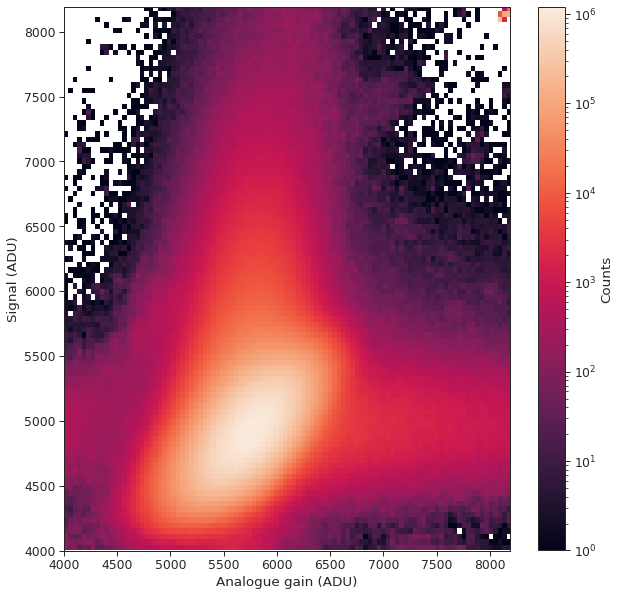

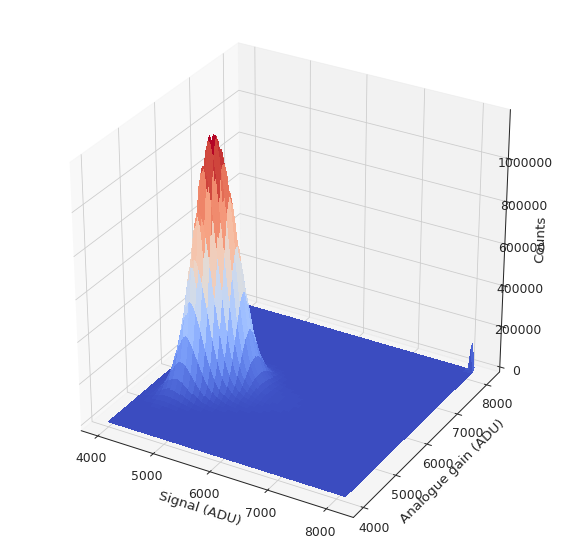

In [25]:
hist, bins_x, bins_y = calgs.histogram2d(raw[:,0,...].flatten().astype(np.float32),
                                         raw[:,1,...].flatten().astype(np.float32),
                                         bins=(100, 100),
                                         range=[[4000, 8192], [4000, 8192]])
do_2d_plot(hist, (bins_x, bins_y), "Signal (ADU)", "Analogue gain (ADU)")
do_3d_plot(hist, (bins_x, bins_y), "Signal (ADU)", "Analogue gain (ADU)")

### Signal vs. Digitized Gain ###

The following plot shows plots signal vs. digitized gain

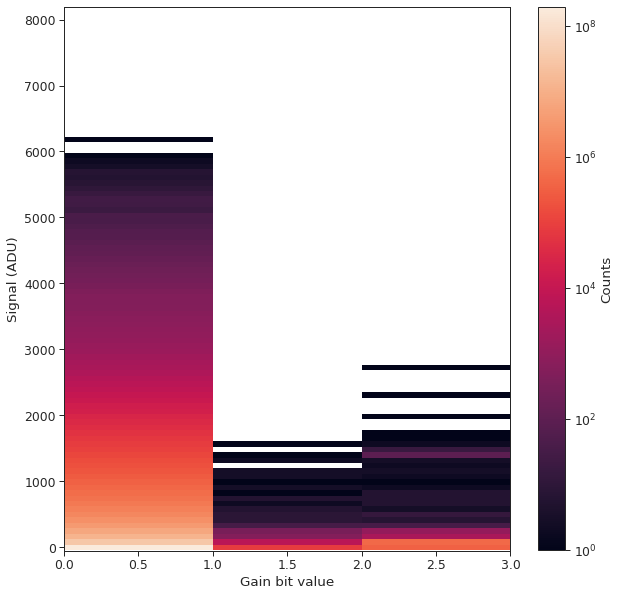

In [26]:
hist, bins_x, bins_y = calgs.histogram2d(corrected.flatten().astype(np.float32),
                                         gains.flatten().astype(np.float32), bins=(100, 3),
                                         range=[[-50, 8192], [0, 3]])
do_2d_plot(hist, (bins_x, bins_y), "Signal (ADU)", "Gain bit value")

In [27]:
print(f"Gain statistics in %")
table = [[f'{gains[gains==0].size/gains.size*100:.02f}',
          f'{gains[gains==1].size/gains.size*100:.03f}',
          f'{gains[gains==2].size/gains.size*100:.03f}']] 
md = display(Latex(tabulate.tabulate(table, tablefmt='latex',
                                     headers=["High", "Medium", "Low"])))

Gain statistics in %


<IPython.core.display.Latex object>

### Intensity per Pulse ###

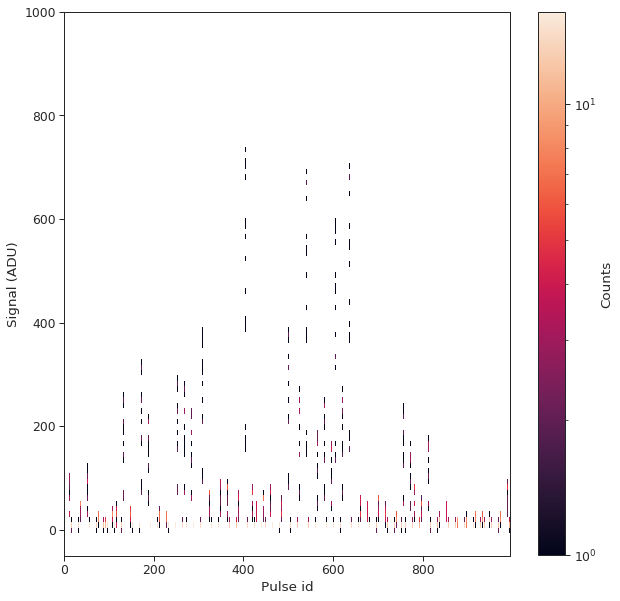

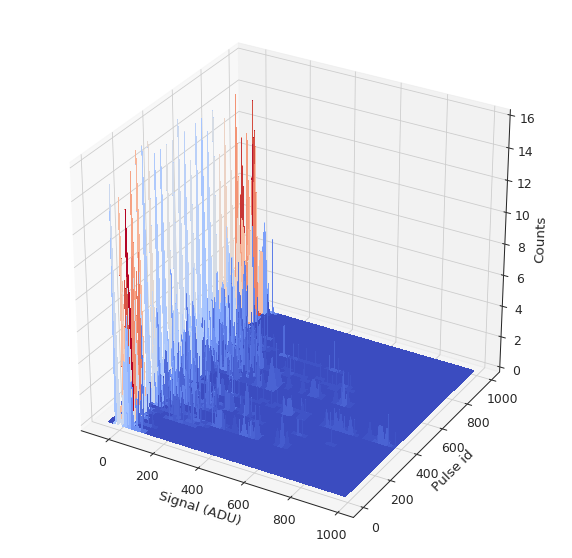

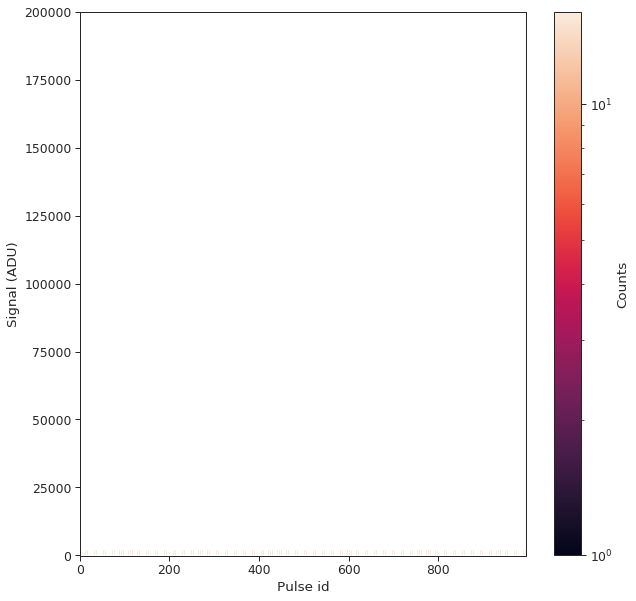

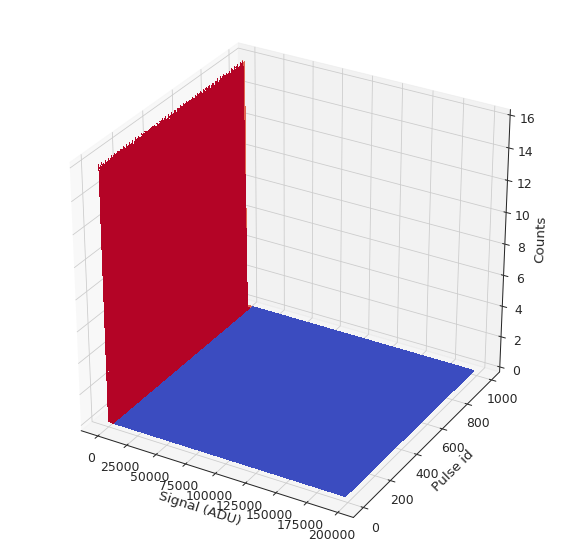

In [28]:
pulse_range = [np.min(pulseId[pulseId>=0]), np.max(pulseId[pulseId>=0])]

mean_data = np.nanmean(corrected, axis=(2, 3))
hist, bins_x, bins_y = calgs.histogram2d(mean_data.flatten().astype(np.float32),
                                      pulseId.flatten().astype(np.float32),
                                      bins=(100, int(pulse_range[1])),
                                      range=[[-50, 1000], pulse_range])

do_2d_plot(hist, (bins_x, bins_y), "Signal (ADU)", "Pulse id")
do_3d_plot(hist, (bins_x, bins_y), "Signal (ADU)", "Pulse id")

hist, bins_x, bins_y = calgs.histogram2d(mean_data.flatten().astype(np.float32),
                                      pulseId.flatten().astype(np.float32),
                                      bins=(100,  int(pulse_range[1])),
                                      range=[[-50, 200000], pulse_range])

do_2d_plot(hist, (bins_x, bins_y), "Signal (ADU)", "Pulse id")
do_3d_plot(hist, (bins_x, bins_y), "Signal (ADU)", "Pulse id")

### Baseline shift ###

Estimated base-line shift with respect to the total ADU counts of corrected image.

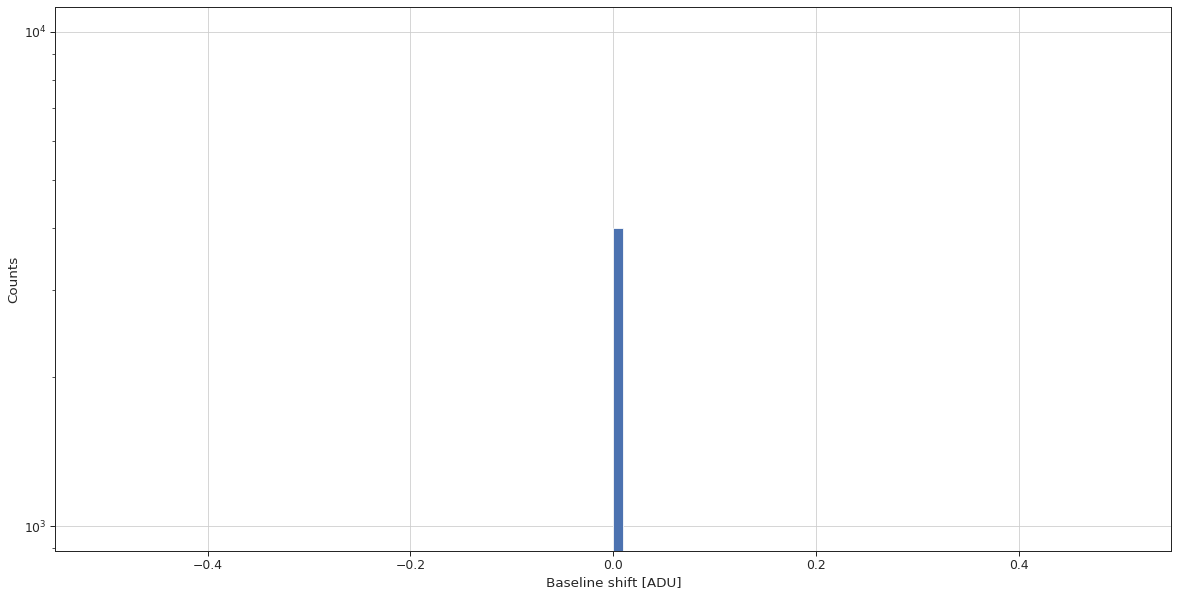

In [29]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
h = ax.hist(blshift.flatten(), bins=100, log=True)
_ = plt.xlabel('Baseline shift [ADU]')
_ = plt.ylabel('Counts')
_ = ax.grid()

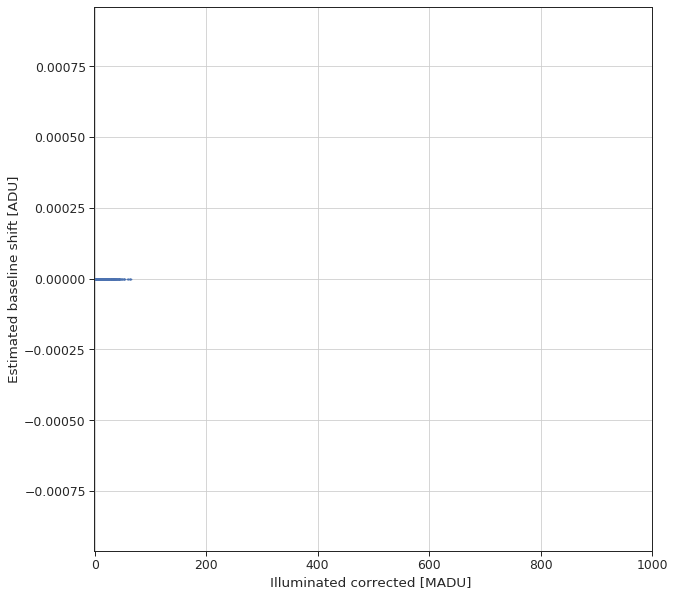

In [30]:
fig = plt.figure(figsize=(10, 10))
corrected_ave = np.nansum(corrected, axis=(2, 3))
plt.scatter(corrected_ave.flatten()/10**6, blshift.flatten(), s=0.9)
plt.xlim(-1, 1000)
plt.grid()
plt.xlabel('Illuminated corrected [MADU] ')
_ = plt.ylabel('Estimated baseline shift [ADU]')

In [31]:
display(Markdown('### Raw preview ###\n'))
display(Markdown(f'Mean over images of the RAW data\n'))

### Raw preview ###


Mean over images of the RAW data


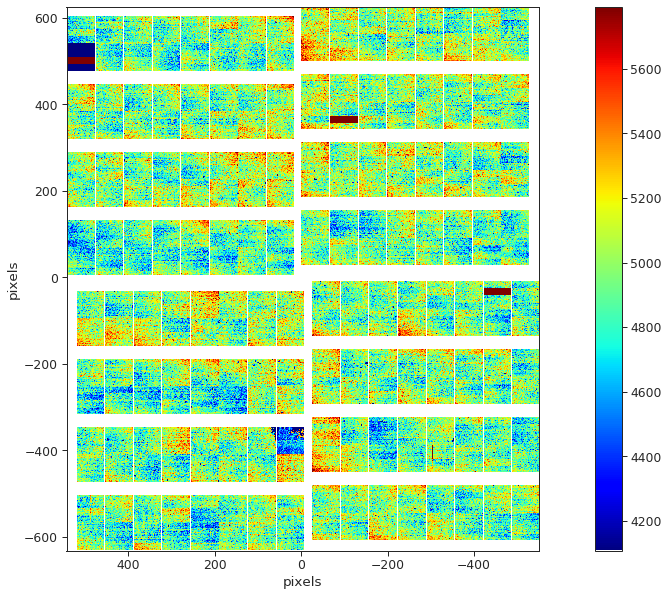

In [32]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
data = np.mean(raw[:, 0, ...], axis=0)
vmin, vmax = get_range(data, 5)
ax = geom.plot_data_fast(data, ax=ax, cmap="jet", vmin=vmin, vmax=vmax)

Single shot of the RAW data from cell 1 


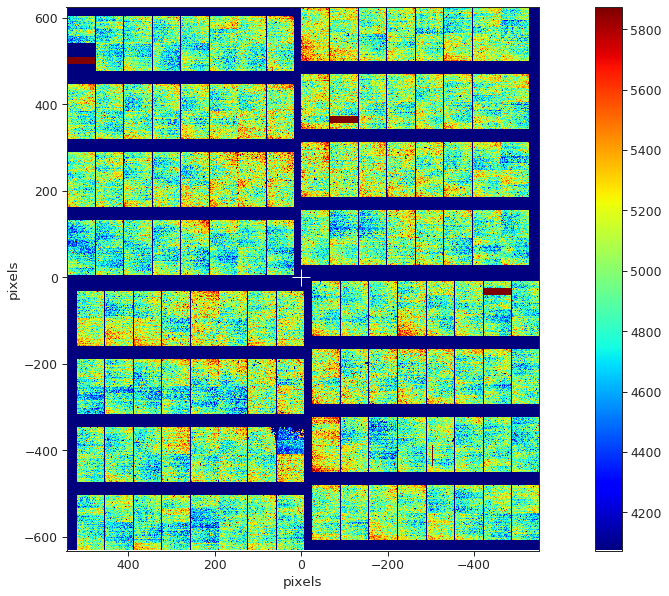

In [33]:
display(Markdown(f'Single shot of the RAW data from cell {np.max(cellId[cell_id_preview])} \n'))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
vmin, vmax = get_range(raw[cell_id_preview, 0, ...], 5)
ax = geom.plot_data_fast(raw[cell_id_preview, 0, ...], ax=ax, cmap="jet", vmin=vmin, vmax=vmax)

In [34]:
display(Markdown('### Corrected preview ###\n'))
display(Markdown(f'A single shot image from cell {np.max(cellId[cell_id_preview])} \n'))

### Corrected preview ###


A single shot image from cell 1 


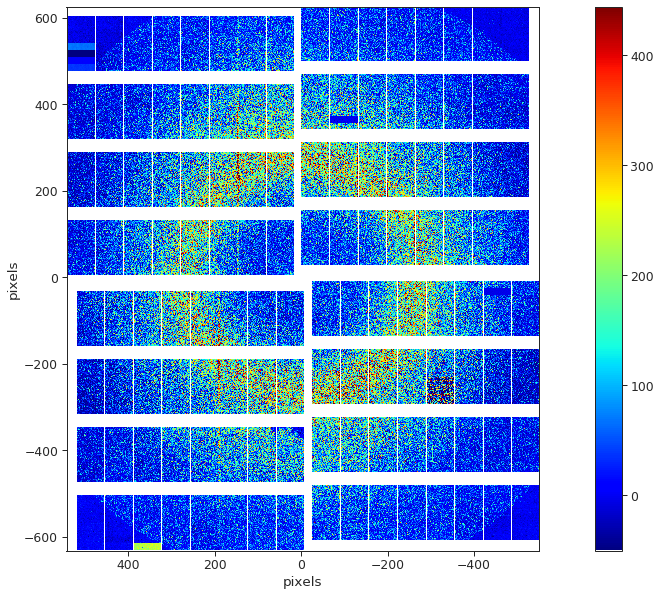

In [35]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
vmin, vmax = get_range(corrected[cell_id_preview], 7, -50)
vmin = - 50
ax = geom.plot_data_fast(corrected[cell_id_preview], ax=ax, cmap="jet", vmin=vmin, vmax=vmax)

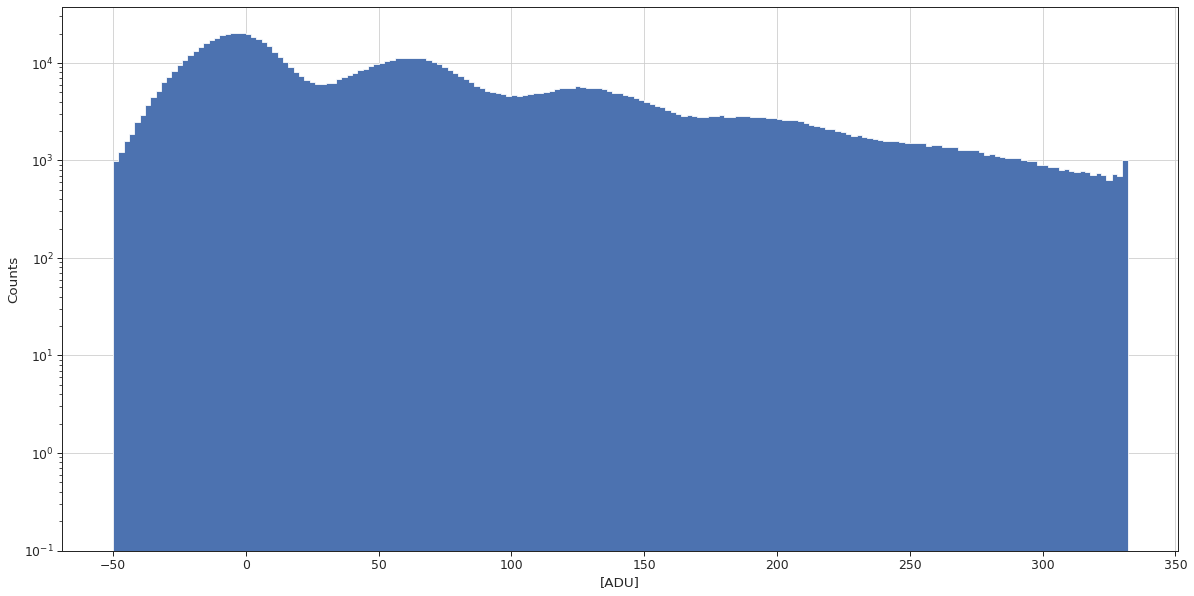

In [36]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
vmin, vmax = get_range(corrected[cell_id_preview], 5, -50)
nbins = np.int((vmax + 50) / 2)
h = ax.hist(corrected[cell_id_preview].flatten(), 
            bins=nbins, range=(-50, vmax), 
            histtype='stepfilled', log=True)
_ = plt.xlabel('[ADU]')
_ = plt.ylabel('Counts')
_ = ax.grid()

In [37]:
display(Markdown('### Mean CORRECTED Preview ###\n'))
display(Markdown(f'A mean across one train \n'))

### Mean CORRECTED Preview ###


A mean across one train 


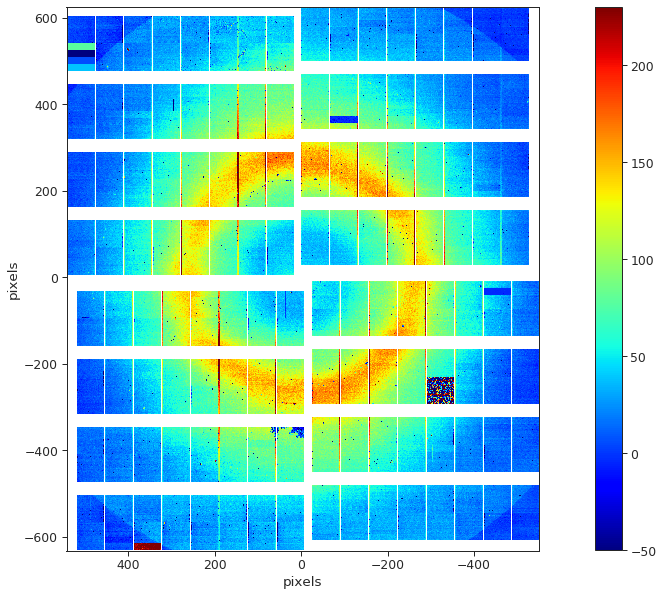

In [38]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
data = np.mean(corrected, axis=0)
vmin, vmax = get_range(data, 7)
ax = geom.plot_data_fast(data, ax=ax, cmap="jet", vmin=-50, vmax=vmax)

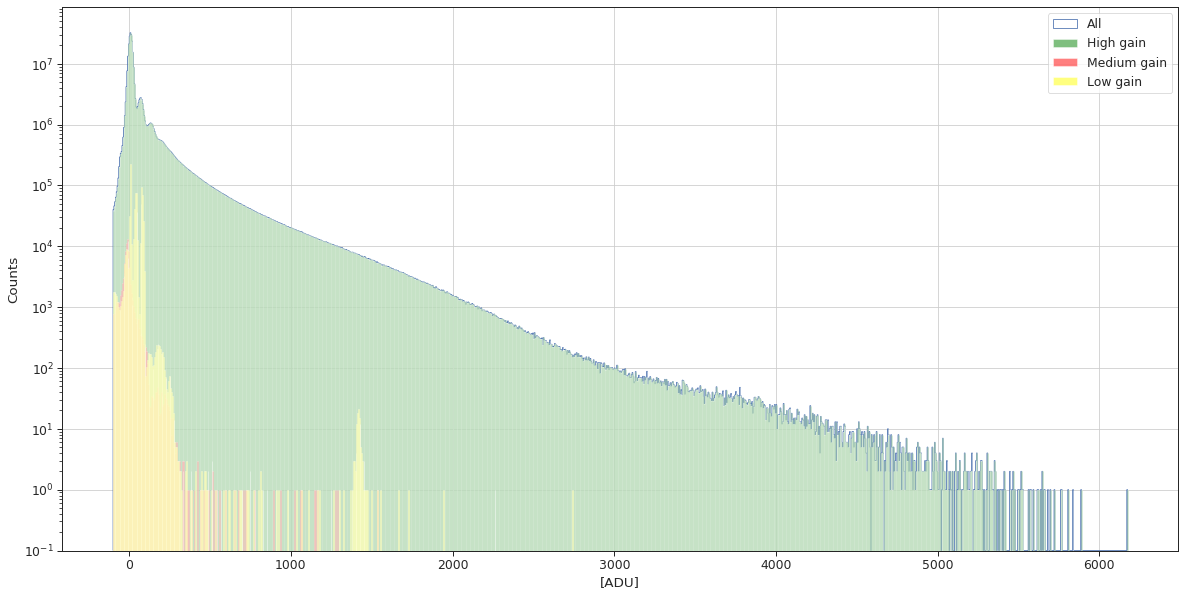

In [39]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
vmin, vmax = get_range(corrected, 10, -100)
vmax = np.nanmax(corrected)
if vmax > 50000:
    vmax=50000
nbins = np.int((vmax + 100) / 5)
h = ax.hist(corrected.flatten(), bins=nbins,
            range=(-100, vmax), histtype='step', log=True, label = 'All')
_ = ax.hist(corrected[gains == 0].flatten(), bins=nbins, range=(-100, vmax),
            alpha=0.5, log=True, label='High gain', color='green')
_ = ax.hist(corrected[gains == 1].flatten(), bins=nbins, range=(-100, vmax),
            alpha=0.5, log=True, label='Medium gain', color='red')
_ = ax.hist(corrected[gains == 2].flatten(), bins=nbins,
            range=(-100, vmax), alpha=0.5, log=True, label='Low gain', color='yellow')
_ = ax.legend()
_ = ax.grid()
_ = plt.xlabel('[ADU]')
_ = plt.ylabel('Counts')


In [40]:
display(Markdown('### Maximum GAIN Preview ###\n'))
display(Markdown(f'The per pixel maximum across one train for the digitized gain'))

### Maximum GAIN Preview ###


The per pixel maximum across one train for the digitized gain

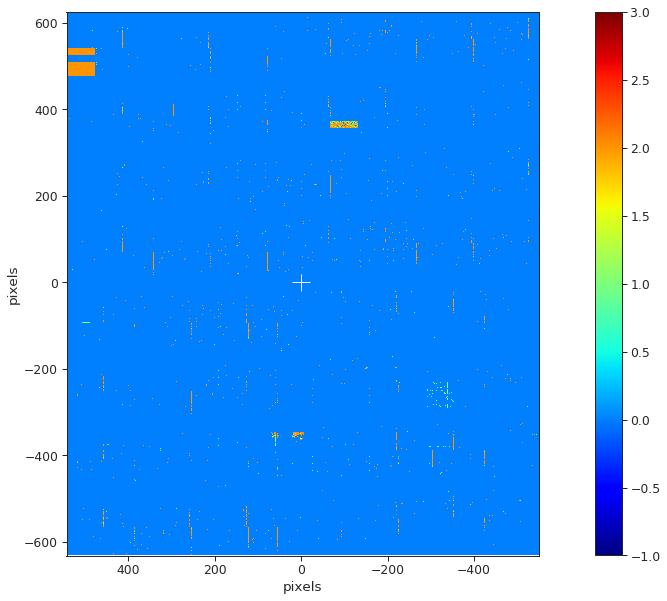

In [41]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax = geom.plot_data_fast(np.max(gains, axis=0), ax=ax,
                         cmap="jet", vmin=-1, vmax=3)

## Bad Pixels ##
The mask contains dedicated entries for all pixels and memory cells as well as all three gains stages. Each mask entry is encoded in 32 bits as:

In [42]:
table = []
for item in BadPixels:
    table.append((item.name, "{:016b}".format(item.value)))
md = display(Latex(tabulate.tabulate(table, tablefmt='latex',
                                     headers=["Bad pixel type", "Bit mask"])))

<IPython.core.display.Latex object>

In [43]:
display(Markdown(f'### Single Shot Bad Pixels ### \n'))
display(Markdown(f'A single shot bad pixel map from cell {np.max(cellId[cell_id_preview])} \n'))

### Single Shot Bad Pixels ### 


A single shot bad pixel map from cell 1 


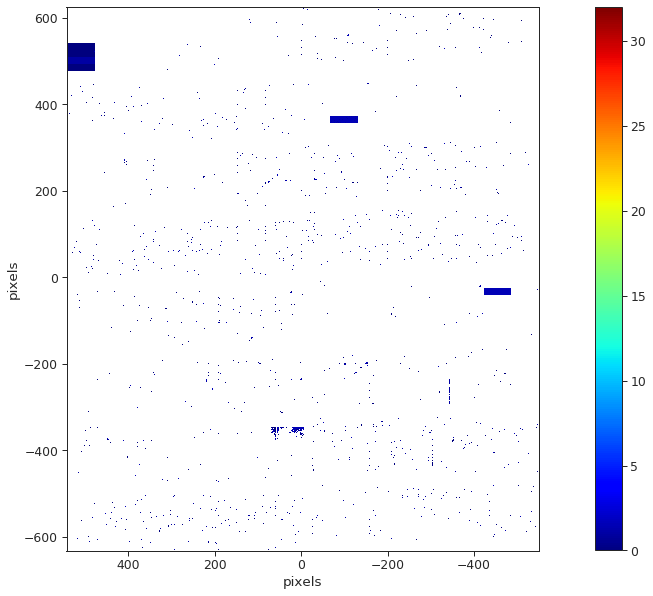

In [44]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax = geom.plot_data_fast(np.log2(mask[cell_id_preview]), ax=ax, vmin=0, vmax=32, cmap="jet")

### Percentage of Bad Pixels across one train  ###

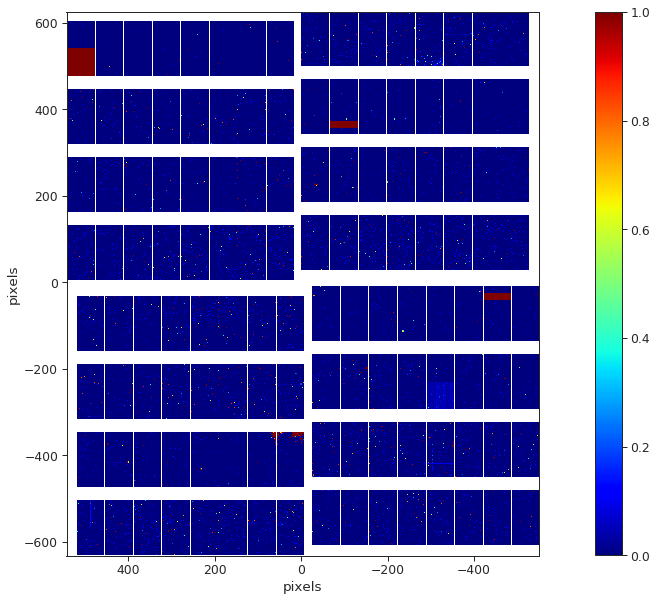

In [45]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax = geom.plot_data_fast(np.mean(mask>0, axis=0),
                         vmin=0, ax=ax, vmax=1, cmap="jet")

### Percentage of Bad Pixels across one train. Only Dark Related ###

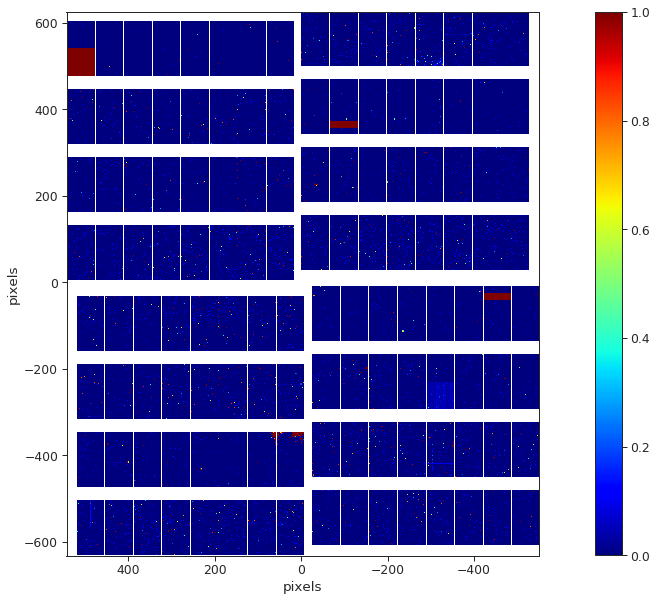

In [46]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
cm = np.copy(mask)
cm[cm > BadPixels.NO_DARK_DATA.value] = 0
ax = geom.plot_data_fast(np.mean(cm>0, axis=0),
                         vmin=0, ax=ax, vmax=1, cmap="jet")